In [18]:
# 1. Setup and Data Loading
# Import necessary libraries and load the dataset.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6) # Default figure size


# Load the dataset
try:
    df_raw = pd.read_csv('EM140_A2_data.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: EM140_A2_data.csv not found.")
    print("Please upload the file to your Colab environment.")
    # Stop execution if file not found
    raise

# Make a copy for cleaning
df = df_raw.copy()

Dataset loaded successfully.


In [4]:
# 2.1 Dataset Description (Initial Inspection)
print("--- Initial Dataset Info ---")
df.info()

print("\n--- Initial Dataset Shape ---")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

print("\n--- First 5 Rows ---")
print(df.head())

print("\n--- Basic Statistics (Numerical) ---")
print(df.describe())

print("\n--- Basic Statistics (Categorical/Object) ---")
print(df.describe(include=['object']))

--- Initial Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  int64  
 1   brand             10000 non-null  object 
 2   model             10000 non-null  object 
 3   year              10000 non-null  int64  
 4   condition         10000 non-null  object 
 5   kilometres        10000 non-null  int64  
 6   transmission      10000 non-null  object 
 7   drive_type        9999 non-null   object 
 8   body_type         9999 non-null   object 
 9   fuel_type         9999 non-null   object 
 10  fuel_consumption  9999 non-null   float64
 11  cylinder          10000 non-null  int64  
 12  engine_size       10000 non-null  float64
 13  exterior_colour   10000 non-null  object 
 14  doors             9999 non-null   float64
 15  seats             9999 non-null   float64
 16  suburb      

In [44]:
# 2.2 Data Quality Assessment
# --- Handling Missing Data ---

# --- Display Missing Values Before Handling ---
print("\n--- Missing Values Before Handling ---")
print(df.isnull().sum())

# --- Handle Missing 'fuel_consumption' ---
if 'fuel_consumption' in df.columns and df['fuel_consumption'].isnull().any():
    grouping_cols = ['fuel_type', 'body_type']

    if all(col in df.columns for col in grouping_cols):
        # Group by 'fuel_type' and 'body_type' to impute missing values with group median
        df['fuel_consumption'] = df.groupby(grouping_cols)['fuel_consumption'].transform(
            lambda x: x.fillna(x.median())
        )

        # Fill any remaining NaNs with global median
        global_median = df['fuel_consumption'].median()
        df['fuel_consumption'].fillna(global_median, inplace=True)
        print("\nImputed missing 'fuel_consumption' values.")
    else:
        print("\nWarning: Grouping columns not found. Using global median instead.")
        df['fuel_consumption'].fillna(df['fuel_consumption'].median(), inplace=True)

# --- Drop Rows with Missing Values in Key Columns ---
cols_to_check = ['engine_size', 'drive_type', 'cylinder', 'doors', 'seats']
existing_cols = [col for col in cols_to_check if col in df.columns]

initial_rows = df.shape[0]
df.dropna(subset=existing_cols, inplace=True)
rows_dropped = initial_rows - df.shape[0]
print(f"\nDropped {rows_dropped} rows with missing values in key columns.")

# --- Handle Missing 'suburb' Values ---
if 'suburb' in df.columns:
    missing_before = df['suburb'].isnull().sum()
    print(f"\nMissing 'suburb' values before handling: {missing_before}")
    # Drop or impute
    df.dropna(subset=['suburb'], inplace=True)  # Optionally drop rows with missing 'suburb'
    missing_after = df['suburb'].isnull().sum()

# --- Final Check ---
print("\n--- Missing Values After Handling ---")
print(df.isnull().sum())



--- Missing Values Before Handling ---
id                  0
brand               0
model               0
year                0
condition           0
kilometres          0
transmission        0
drive_type          0
body_type           0
fuel_type           0
fuel_consumption    0
cylinder            0
engine_size         0
exterior_colour     0
doors               0
seats               0
suburb              0
state               0
price               0
car_age             0
dtype: int64

Dropped 0 rows with missing values in key columns.

Missing 'suburb' values before handling: 0

--- Missing Values After Handling ---
id                  0
brand               0
model               0
year                0
condition           0
kilometres          0
transmission        0
drive_type          0
body_type           0
fuel_type           0
fuel_consumption    0
cylinder            0
engine_size         0
exterior_colour     0
doors               0
seats               0
suburb              

In [34]:
# 2.2 Data Quality Assessment
# --- Data Type Correction ---
# Clean and convert 'price' column
if 'price' in df.columns:
    print("\nCleaning 'price' column...")
    # Remove commas
    df['price'] = df['price'].astype(str).str.replace(',', '', regex=False)
    # Convert to numeric, coercing errors (turns non-numeric to NaN)
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    # Check for NaNs introduced by coercion
    price_na_count = df['price'].isnull().sum()
    if price_na_count > 0:
        print(f"Warning: {price_na_count} rows had non-numeric prices and were set to NaN. Dropping these rows.")
        df.dropna(subset=['price'], inplace=True)
    df['price'] = df['price'].astype(float) # Ensure it's float
    print("'price' column cleaned and converted to numeric.")
else:
    print("Warning: 'price' column not found.")

# Convert other columns to appropriate types if necessary (based on metadata)
# Example: Ensure integer types where appropriate, handling potential floats from loading/imputation
int_cols = ['year', 'kilometres', 'cylinder'] # Add 'doors', 'seats' if needed after checking
for col in int_cols:
    if col in df.columns:
        # Handle potential NaNs before converting to int (though we dropped NaNs earlier)
        if df[col].isnull().any():
             print(f"Warning: NaNs found in {col} before int conversion. Filling with 0 or median might be needed.")
             # df[col].fillna(0, inplace=True) # Example: fill with 0, choose appropriate strategy
        # Convert floats resulting from calculations/imputation to int if applicable
        # Use errors='ignore' if you want to skip columns that can't be converted
        try:
            df[col] = df[col].astype(int)
        except ValueError as e:
             print(f"Could not convert column {col} to int: {e}")

# 2.2 Data Quality Assessment
print("\n--- Data Types After Correction ---")
df.info()


Cleaning 'price' column...
'price' column cleaned and converted to numeric.

--- Data Types After Correction ---
<class 'pandas.core.frame.DataFrame'>
Index: 9989 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                9989 non-null   int64  
 1   brand             9989 non-null   object 
 2   model             9989 non-null   object 
 3   year              9989 non-null   int64  
 4   condition         9989 non-null   object 
 5   kilometres        9989 non-null   int64  
 6   transmission      9989 non-null   object 
 7   drive_type        9989 non-null   object 
 8   body_type         9989 non-null   object 
 9   fuel_type         9989 non-null   object 
 10  fuel_consumption  9989 non-null   float64
 11  cylinder          9989 non-null   int64  
 12  engine_size       9989 non-null   float64
 13  exterior_colour   9989 non-null   object 
 14  doors             9989 non-

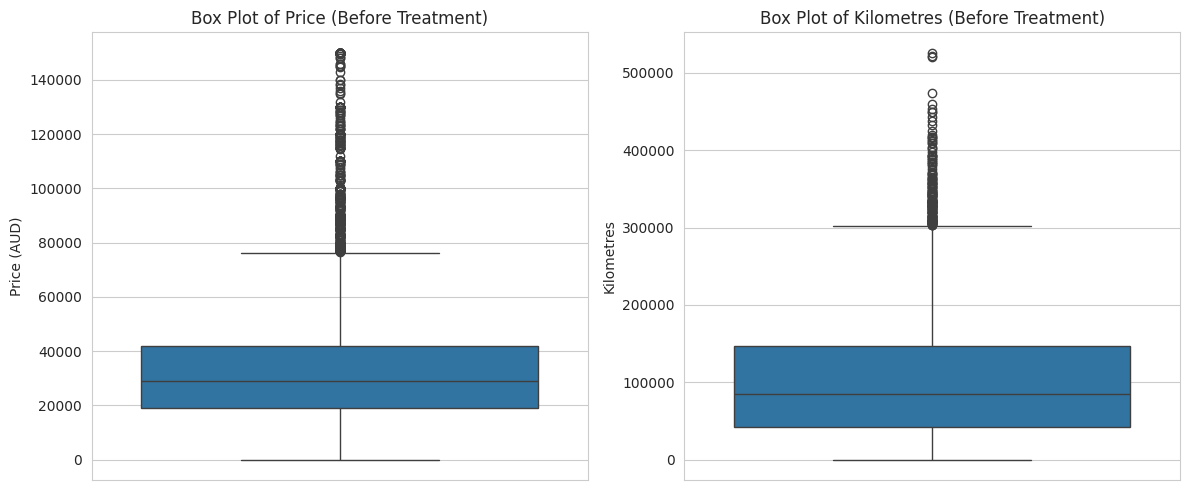


Capped 82 price values above $150,000 AUD.
New maximum price: $150,000 AUD (Original max was $150,000)


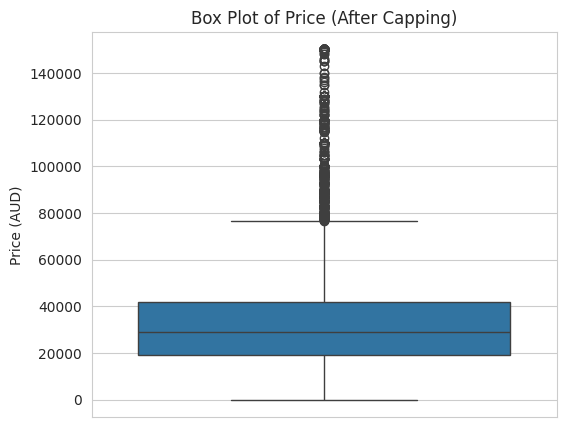


Unique values in 'transmission': ['Automatic' 'Manual']

Unique values in 'condition': ['DEMO' 'USED' 'NEW']


In [35]:
# 2.2 Data Quality Assessment
# --- Outlier Identification and Treatment ---
# Visualize potential outliers in price and kilometres
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['price'])
plt.title('Box Plot of Price (Before Treatment)')
plt.ylabel('Price (AUD)')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['kilometres'])
plt.title('Box Plot of Kilometres (Before Treatment)')
plt.ylabel('Kilometres')
plt.tight_layout()
plt.show()

# Define outlier treatment strategy (capping price)
price_cap = 150000
initial_max_price = df['price'].max()
df['price'] = df['price'].clip(upper=price_cap)
capped_count = (df_raw['price'].astype(str).str.replace(',', '', regex=False).astype(float) > price_cap).sum() # Count on original data before potential NaN drops
print(f"\nCapped {capped_count} price values above ${price_cap:,.0f} AUD.")
print(f"New maximum price: ${df['price'].max():,.0f} AUD (Original max was ${initial_max_price:,.0f})")

# Visualize price after capping
plt.figure(figsize=(6, 5))
sns.boxplot(y=df['price'])
plt.title('Box Plot of Price (After Capping)')
plt.ylabel('Price (AUD)')
plt.show()



# --- Standardize Categorical Values ---
if 'transmission' in df.columns:
    df['transmission'] = df['transmission'].replace({'Auto': 'Automatic', 'Man': 'Manual'})
    print("\nUnique values in 'transmission':", df['transmission'].unique())

if 'condition' in df.columns:
    df['condition'] = df['condition'].replace({'Used': 'Pre-Owned', 'Excellent': 'Great'})
    print("\nUnique values in 'condition':", df['condition'].unique())

if 'fuel_type' in df.columns:
    df['fuel_type'] = df['fuel_type'].replace({'Petrol': 'Petrol/Gas', 'Diesel': 'Diesel/Gas'})

if 'drive_type' in df.columns:
    df['drive_type'] = df['drive_type'].replace({'Front': 'Front-Wheel Drive', 'Rear': 'Rear-Wheel Drive'})

In [36]:
# 2.3 Feature Engineering
# Create 'car_age' feature
current_year = datetime.datetime.now().year
if 'year' in df.columns:
    df['car_age'] = current_year - df['year']
    print(f"\nCreated 'car_age' feature based on current year {current_year}.")
    print(df[['year', 'car_age']].head())
else:
    print("\n'year' column not found, cannot create 'car_age'.")


Created 'car_age' feature based on current year 2025.
   year  car_age
0  2022        3
1  2016        9
2  2012       13
3  2013       12
4  2006       19


In [37]:
# 2.4 Summary of Preprocessing Impact
print("\n--- Dataset Shape After Preprocessing ---")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print("\n--- Final Data Types ---")
df.info()
print("\nPreprocessing complete. Dataset is ready for EDA and Modeling.")


--- Dataset Shape After Preprocessing ---
Rows: 9989, Columns: 20

--- Final Data Types ---
<class 'pandas.core.frame.DataFrame'>
Index: 9989 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                9989 non-null   int64  
 1   brand             9989 non-null   object 
 2   model             9989 non-null   object 
 3   year              9989 non-null   int64  
 4   condition         9989 non-null   object 
 5   kilometres        9989 non-null   int64  
 6   transmission      9989 non-null   object 
 7   drive_type        9989 non-null   object 
 8   body_type         9989 non-null   object 
 9   fuel_type         9989 non-null   object 
 10  fuel_consumption  9989 non-null   float64
 11  cylinder          9989 non-null   int64  
 12  engine_size       9989 non-null   float64
 13  exterior_colour   9989 non-null   object 
 14  doors             9989 non-null   int64  
 15  s

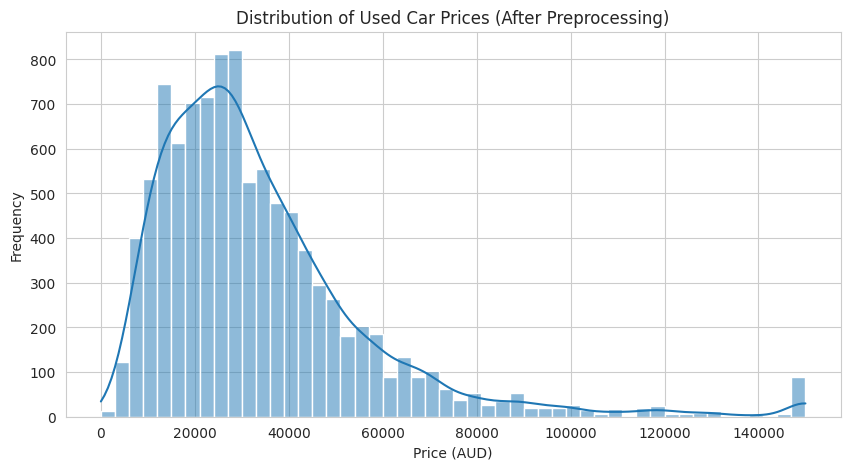


--- Price Statistics ---
count      9989.000000
mean      34071.652117
std       23394.252946
min           0.000000
25%       18980.000000
50%       28950.000000
75%       41999.000000
max      150000.000000
Name: price, dtype: float64


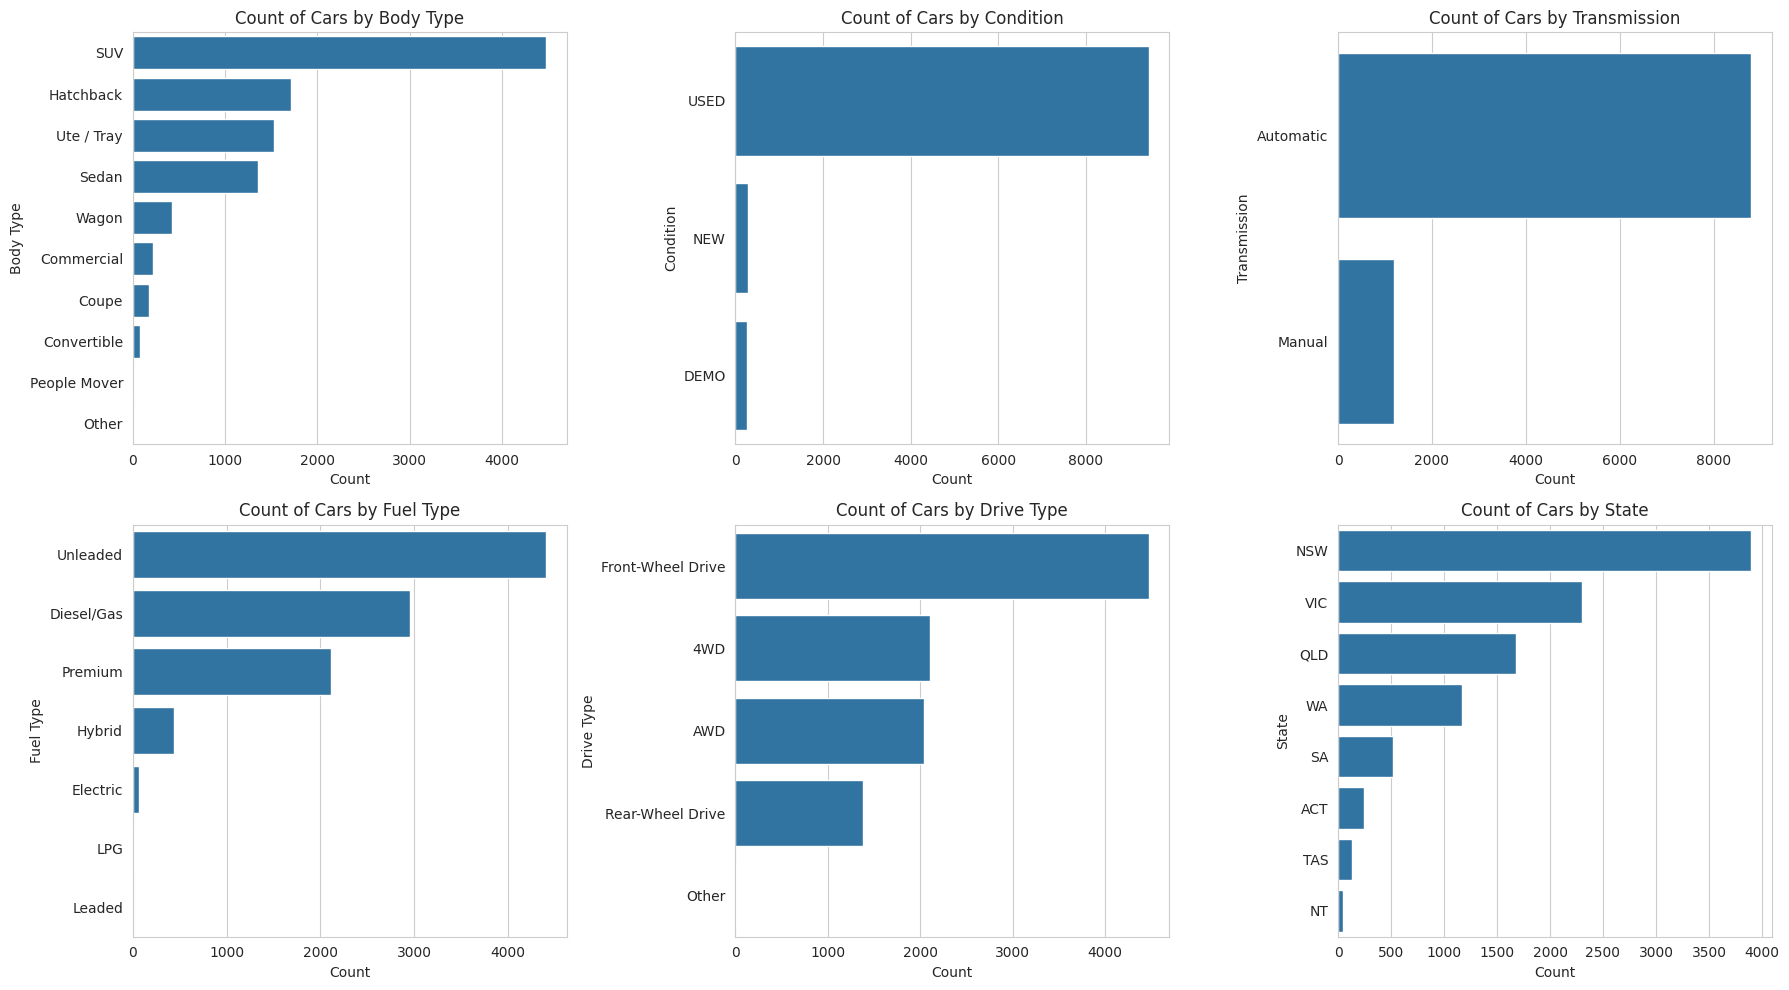

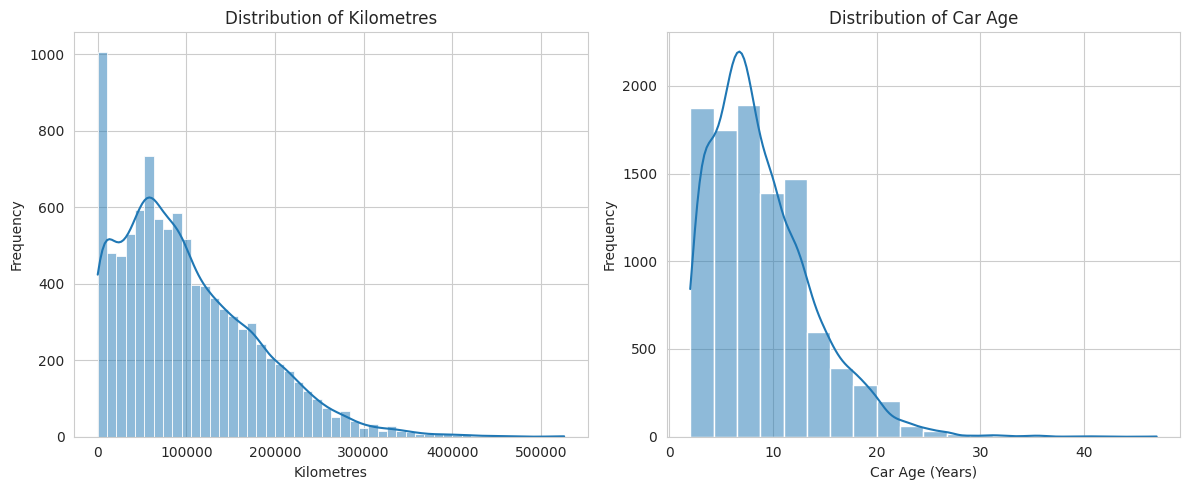


--- Kilometres Statistics ---
count      9989.000000
mean     100069.351687
std       76754.916836
min           1.000000
25%       42253.000000
50%       85273.000000
75%      146445.000000
max      526162.000000
Name: kilometres, dtype: float64

--- Car Age Statistics ---
count    9989.000000
mean        8.876064
std         4.903153
min         2.000000
25%         5.000000
50%         8.000000
75%        12.000000
max        47.000000
Name: car_age, dtype: float64


In [38]:
# 3.1 Overview of Key Car Features

# --- Price Distribution ---
plt.figure(figsize=(10, 5))
sns.histplot(df['price'], kde=True, bins=50)
plt.title('Distribution of Used Car Prices (After Preprocessing)')
plt.xlabel('Price (AUD)')
plt.ylabel('Frequency')
plt.show()
print("\n--- Price Statistics ---")
print(df['price'].describe())

# --- Vehicle Characteristics ---
plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
sns.countplot(y=df['body_type'], order = df['body_type'].value_counts().index)
plt.title('Count of Cars by Body Type')
plt.xlabel('Count')
plt.ylabel('Body Type')

plt.subplot(2, 3, 2)
sns.countplot(y=df['condition'], order = df['condition'].value_counts().index)
plt.title('Count of Cars by Condition')
plt.xlabel('Count')
plt.ylabel('Condition')

plt.subplot(2, 3, 3)
sns.countplot(y=df['transmission'], order = df['transmission'].value_counts().index)
plt.title('Count of Cars by Transmission')
plt.xlabel('Count')
plt.ylabel('Transmission')

plt.subplot(2, 3, 4)
sns.countplot(y=df['fuel_type'], order = df['fuel_type'].value_counts().index)
plt.title('Count of Cars by Fuel Type')
plt.xlabel('Count')
plt.ylabel('Fuel Type')

plt.subplot(2, 3, 5)
sns.countplot(y=df['drive_type'], order = df['drive_type'].value_counts().index)
plt.title('Count of Cars by Drive Type')
plt.xlabel('Count')
plt.ylabel('Drive Type')

plt.subplot(2, 3, 6)
sns.countplot(y=df['state'], order = df['state'].value_counts().index)
plt.title('Count of Cars by State')
plt.xlabel('Count')
plt.ylabel('State')


plt.tight_layout()
plt.show()

# --- Usage Characteristics ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['kilometres'], kde=True, bins=50)
plt.title('Distribution of Kilometres')
plt.xlabel('Kilometres')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df['car_age'], kde=True, bins=20)
plt.title('Distribution of Car Age')
plt.xlabel('Car Age (Years)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\n--- Kilometres Statistics ---")
print(df['kilometres'].describe())
print("\n--- Car Age Statistics ---")
print(df['car_age'].describe())


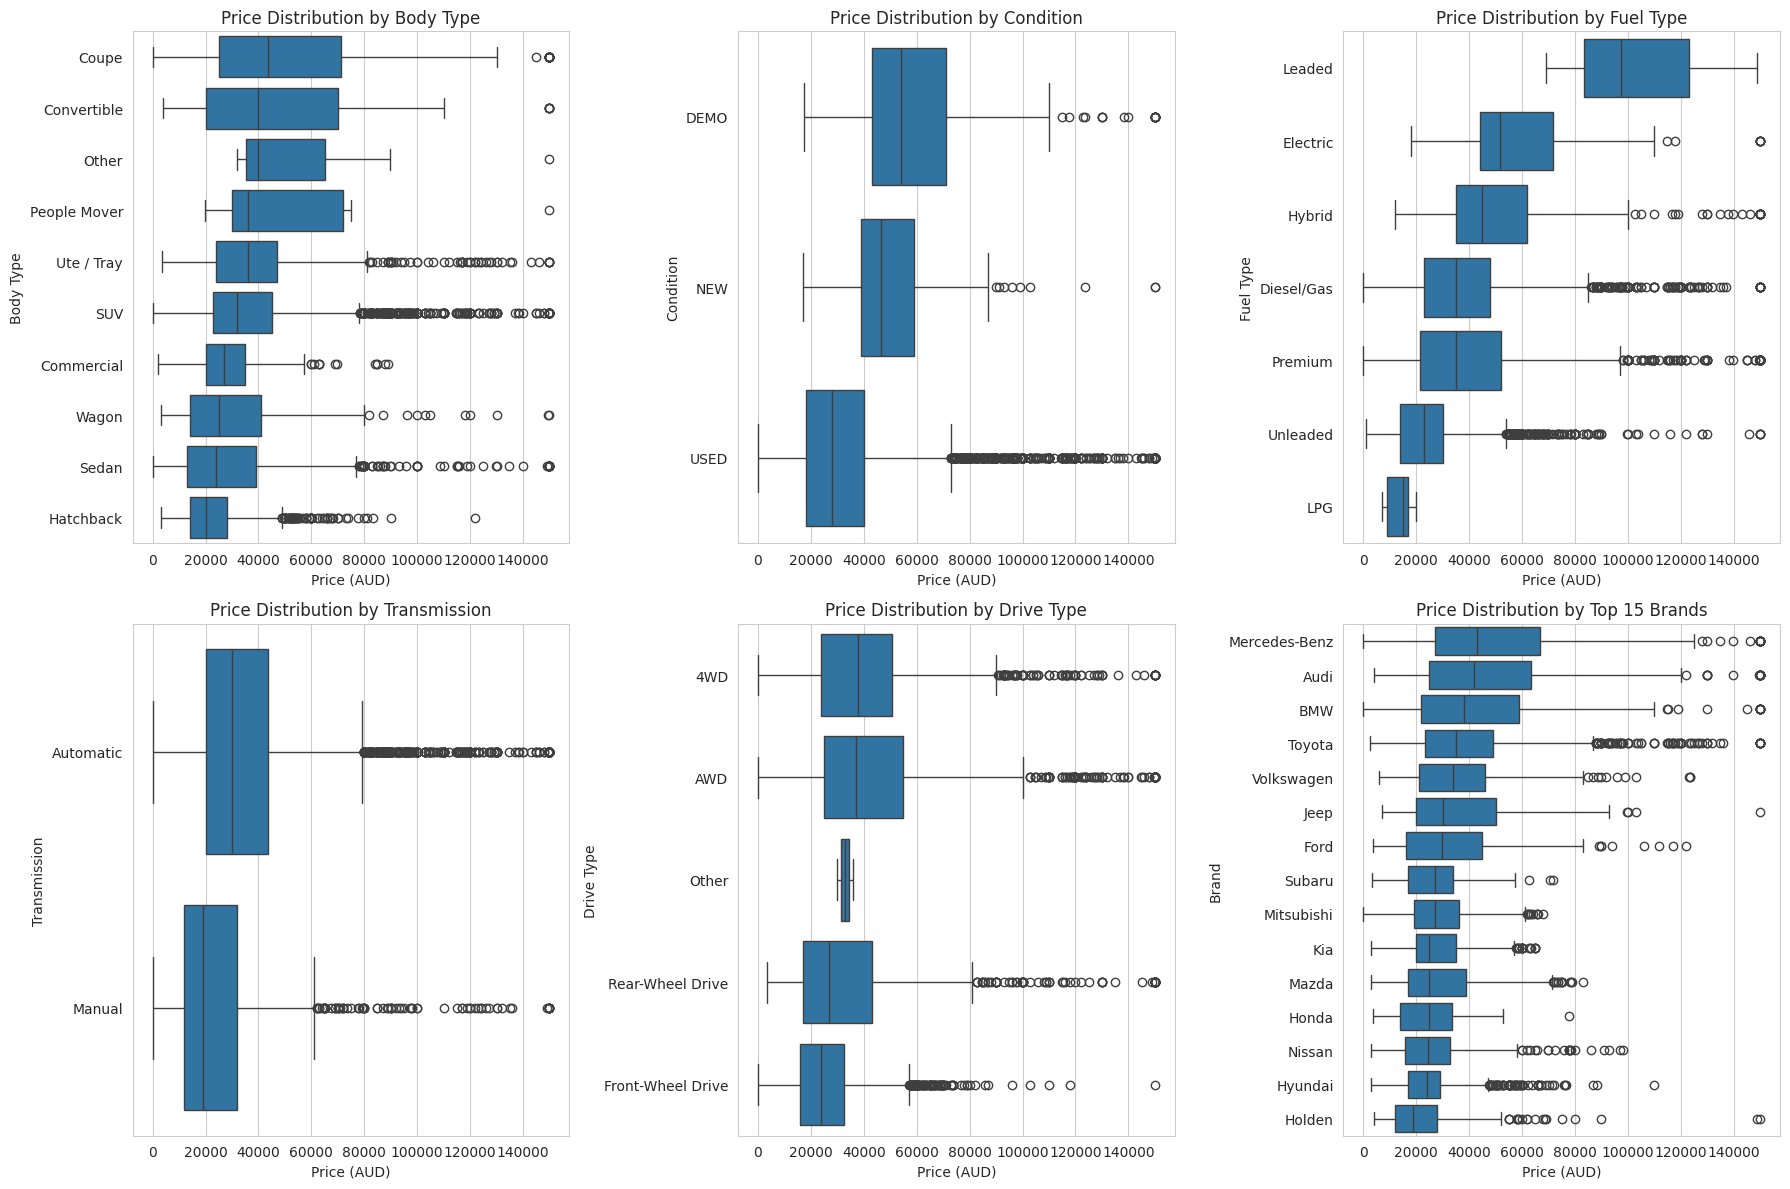

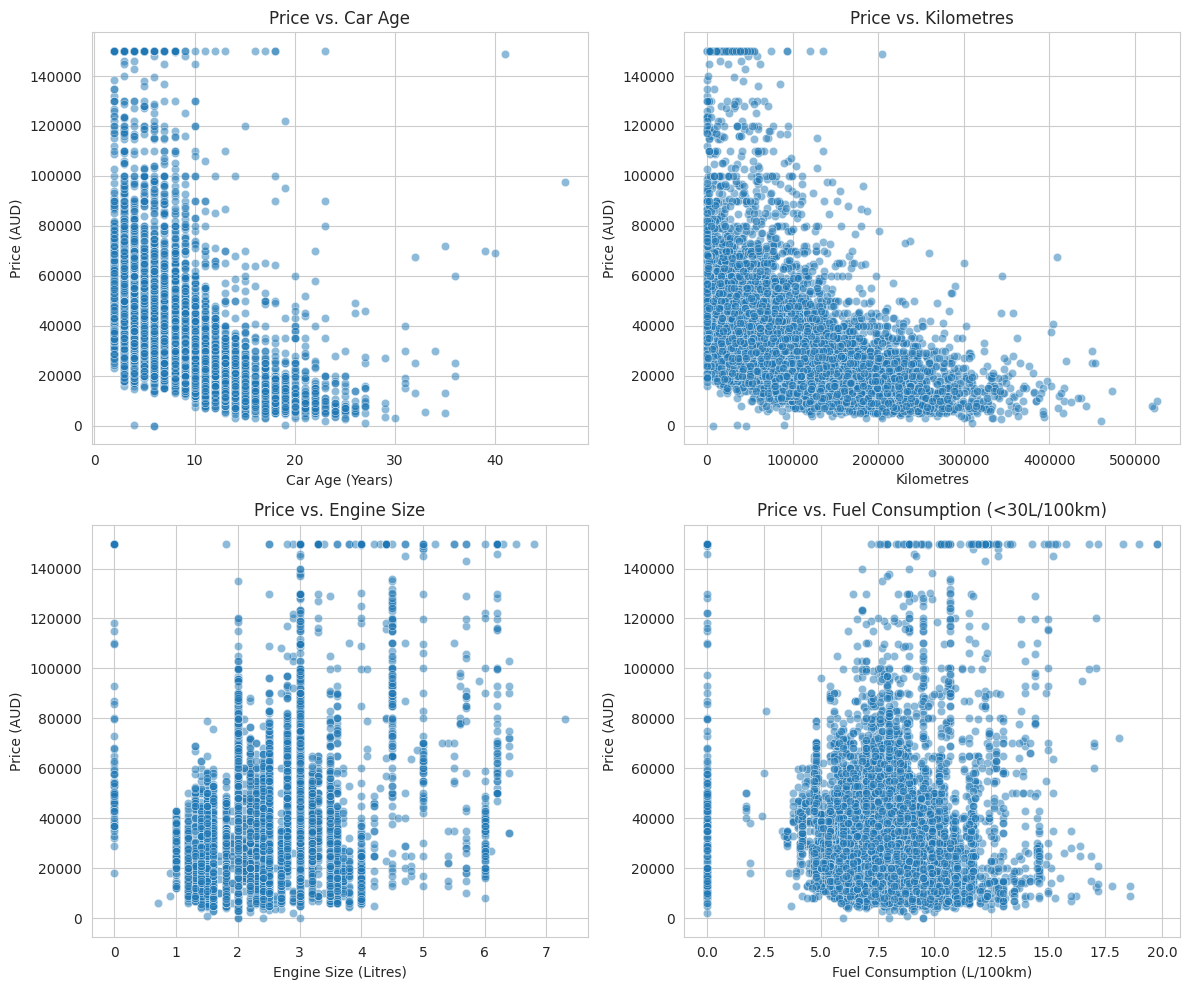


--- Correlation of Numeric Features with Price ---
price               1.000000
year                0.510546
engine_size         0.316303
cylinder            0.313550
fuel_consumption    0.080098
seats               0.061131
id                  0.048984
doors              -0.126189
kilometres         -0.496949
car_age            -0.510546
Name: price, dtype: float64


In [39]:
# 3.2 Car Price Analysis

# --- Price Variation Across Key Features ---
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.boxplot(x='price', y='body_type', data=df, order = df.groupby('body_type')['price'].median().sort_values(ascending=False).index)
plt.title('Price Distribution by Body Type')
plt.xlabel('Price (AUD)')
plt.ylabel('Body Type')

plt.subplot(2, 3, 2)
sns.boxplot(x='price', y='condition', data=df, order = df.groupby('condition')['price'].median().sort_values(ascending=False).index)
plt.title('Price Distribution by Condition')
plt.xlabel('Price (AUD)')
plt.ylabel('Condition')

plt.subplot(2, 3, 3)
sns.boxplot(x='price', y='fuel_type', data=df, order = df.groupby('fuel_type')['price'].median().sort_values(ascending=False).index)
plt.title('Price Distribution by Fuel Type')
plt.xlabel('Price (AUD)')
plt.ylabel('Fuel Type')

plt.subplot(2, 3, 4)
sns.boxplot(x='price', y='transmission', data=df, order = df.groupby('transmission')['price'].median().sort_values(ascending=False).index)
plt.title('Price Distribution by Transmission')
plt.xlabel('Price (AUD)')
plt.ylabel('Transmission')

plt.subplot(2, 3, 5)
sns.boxplot(x='price', y='drive_type', data=df, order = df.groupby('drive_type')['price'].median().sort_values(ascending=False).index)
plt.title('Price Distribution by Drive Type')
plt.xlabel('Price (AUD)')
plt.ylabel('Drive Type')

plt.subplot(2, 3, 6)
# Select top N brands by count for better visualization
top_brands = df['brand'].value_counts().nlargest(15).index
df_top_brands = df[df['brand'].isin(top_brands)]
sns.boxplot(x='price', y='brand', data=df_top_brands, order = df_top_brands.groupby('brand')['price'].median().sort_values(ascending=False).index)
plt.title('Price Distribution by Top 15 Brands')
plt.xlabel('Price (AUD)')
plt.ylabel('Brand')


plt.tight_layout()
plt.show()

# Scatter plots for numerical features vs price
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.scatterplot(x='car_age', y='price', data=df, alpha=0.5)
plt.title('Price vs. Car Age')
plt.xlabel('Car Age (Years)')
plt.ylabel('Price (AUD)')

plt.subplot(2, 2, 2)
sns.scatterplot(x='kilometres', y='price', data=df, alpha=0.5)
plt.title('Price vs. Kilometres')
plt.xlabel('Kilometres')
plt.ylabel('Price (AUD)')

plt.subplot(2, 2, 3)
# Check if 'engine_size' exists and has numeric data before plotting
if 'engine_size' in df.columns and pd.api.types.is_numeric_dtype(df['engine_size']):
    sns.scatterplot(x='engine_size', y='price', data=df, alpha=0.5)
    plt.title('Price vs. Engine Size')
    plt.xlabel('Engine Size (Litres)')
    plt.ylabel('Price (AUD)')
else:
     plt.text(0.5, 0.5, "'engine_size' not available for plotting", ha='center', va='center')
     plt.title('Price vs. Engine Size')


plt.subplot(2, 2, 4)
# Check if 'fuel_consumption' exists and has numeric data before plotting
if 'fuel_consumption' in df.columns and pd.api.types.is_numeric_dtype(df['fuel_consumption']):
    # Filter out potential extreme fuel consumption values for better visualization if needed
    df_filtered_fuel = df[df['fuel_consumption'] < 30] # Example filter
    sns.scatterplot(x='fuel_consumption', y='price', data=df_filtered_fuel, alpha=0.5)
    plt.title('Price vs. Fuel Consumption (<30L/100km)')
    plt.xlabel('Fuel Consumption (L/100km)')
    plt.ylabel('Price (AUD)')
else:
    plt.text(0.5, 0.5, "'fuel_consumption' not available for plotting", ha='center', va='center')
    plt.title('Price vs. Fuel Consumption')


plt.tight_layout()
plt.show()


# --- Identification of Price Influencers (Correlation) ---
# Select only numeric columns for correlation calculation
numeric_cols = df.select_dtypes(include=np.number).columns
correlation_matrix = df[numeric_cols].corr()

# Correlation with Price
price_correlation = correlation_matrix['price'].sort_values(ascending=False)
print("\n--- Correlation of Numeric Features with Price ---")
print(price_correlation)

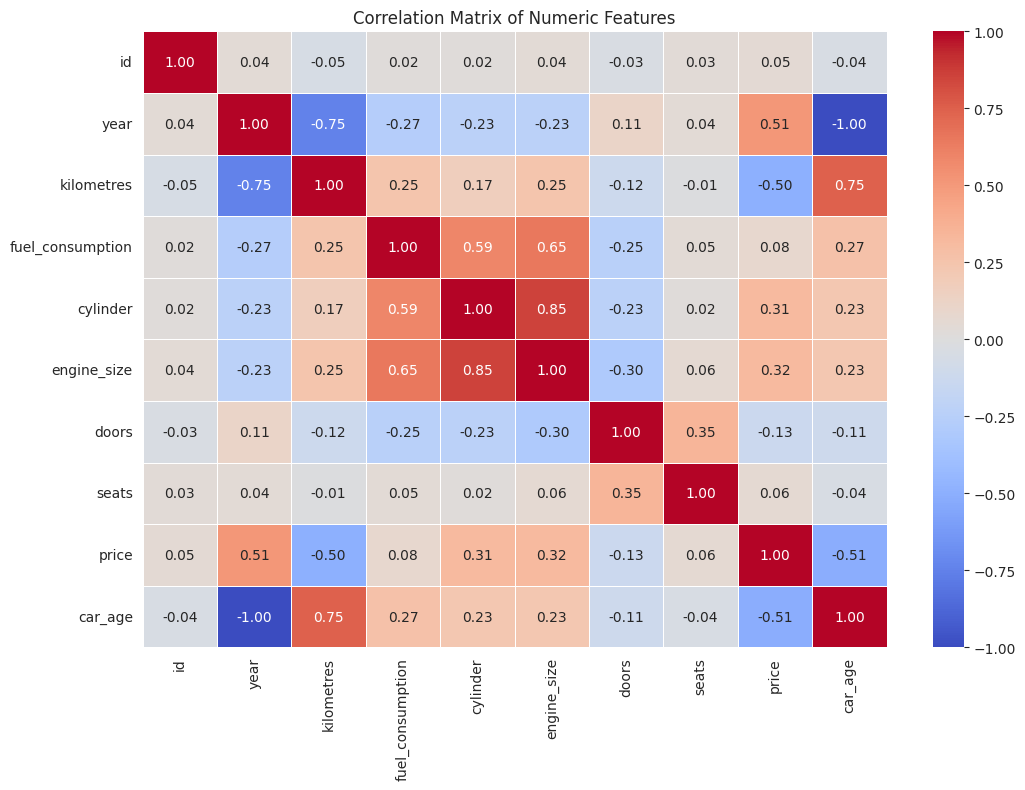

In [45]:
# 3.3 Other Insights: Feature Relationships
# Heatmap for numeric features
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [41]:
# 4. Machine Learning Approach and Findings (Corresponds to Report Section 4)
# 4.1 Machine Learning Task Definition & Feature Selection and Data Preparation for Modeling

# Target variable
target = 'price'

# Feature selection (based on EDA and relevance, excluding high cardinality/ID cols for simplicity)
# Exclude 'id', 'model', 'suburb', 'exterior_colour' initially.
# Also exclude 'year' as 'car_age' is engineered.
features = ['brand', 'condition', 'kilometres', 'transmission',
            'drive_type', 'body_type', 'fuel_type', 'fuel_consumption',
            'cylinder', 'engine_size', 'doors', 'seats', 'state', 'car_age']

# Ensure all selected features exist in the dataframe
features = [f for f in features if f in df.columns]
print(f"Selected features for modeling: {features}")

X = df[features]
y = df[target]

# Identify categorical and numerical features AFTER selection
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

print(f"\nCategorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")


# --- Train/Test Data Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nData split into training ({X_train.shape[0]} rows) and testing ({X_test.shape[0]} rows) sets.")

# --- Preprocessing Steps (Encoding & Scaling) ---
# Create preprocessing pipelines for numerical and categorical features
# Use handle_unknown='ignore' for OneHotEncoder to handle potential new categories in test set
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features) # Use sparse_output=False for easier handling later if needed
    ],
    remainder='passthrough' # Keep other columns if any (shouldn't be any based on selection)
)

print("\nPreprocessor defined (StandardScaler for numeric, OneHotEncoder for categorical).")

Selected features for modeling: ['brand', 'condition', 'kilometres', 'transmission', 'drive_type', 'body_type', 'fuel_type', 'fuel_consumption', 'cylinder', 'engine_size', 'doors', 'seats', 'state', 'car_age']

Categorical features: ['brand', 'condition', 'transmission', 'drive_type', 'body_type', 'fuel_type', 'state']
Numerical features: ['kilometres', 'fuel_consumption', 'cylinder', 'engine_size', 'doors', 'seats', 'car_age']


In [ ]:
# 4.3 Model Selection and Justification
# Models selected: Linear Regression (baseline), Random Forest Regressor (ensemble)
# Justification: Linear Regression for simplicity/interpretability baseline.
# Random Forest for handling potential non-linearities and feature interactions.


--- Training Linear Regression ---
Linear Regression training complete.

--- Linear Regression Performance ---
R-squared (R²): 0.7423
Mean Absolute Error (MAE): $7,913.95 AUD
Root Mean Squared Error (RMSE): $12,261.77 AUD

--- Training Random Forest Regressor ---
Random Forest training complete.

--- Random Forest Performance ---
R-squared (R²): 0.9046
Mean Absolute Error (MAE): $4,266.03 AUD
Root Mean Squared Error (RMSE): $7,459.86 AUD

--- Model Comparison ---
Linear Regression: R²=0.7423, MAE=$7,913.95, RMSE=$12,261.77
Random Forest:     R²=0.9046, MAE=$4,266.03, RMSE=$7,459.86

Random Forest outperformed Linear Regression based on R².
The average prediction error (MAE) for Random Forest is approximately $4,266 AUD.

Model Strengths/Limitations:
- Linear Regression: Interpretable coefficients but may underfit complex relationships.
- Random Forest: Captures non-linearities, robust, but less interpretable ('black box'). Performance depends on data quality.


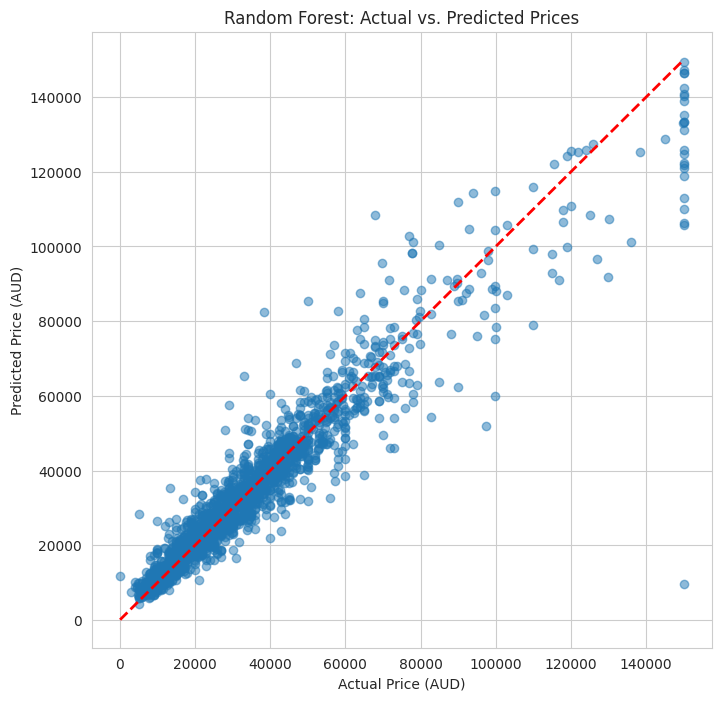

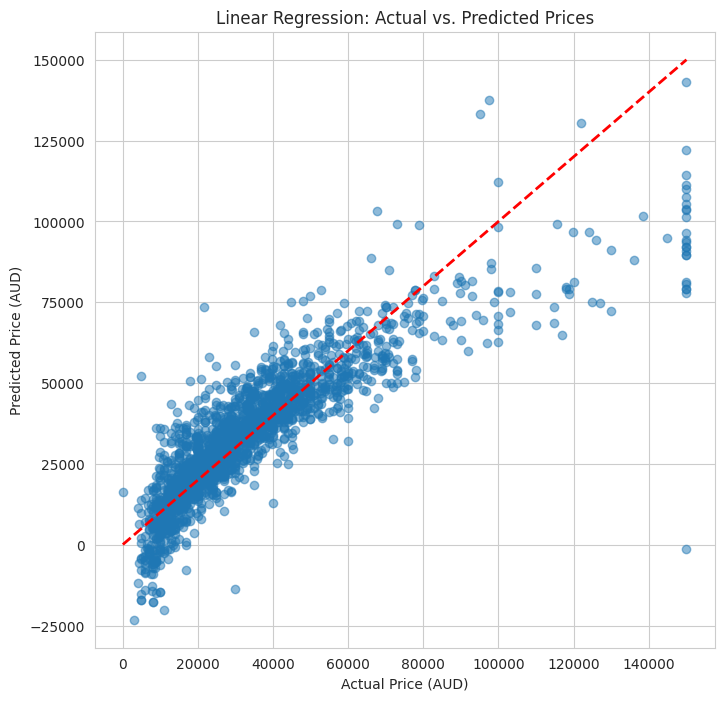

In [47]:
# 4.4 Model Training and Performance Evaluation

# --- Model 1: Linear Regression ---
print("\n--- Training Linear Regression ---")
# Create pipeline
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', LinearRegression())])

# Train the model
lr_pipeline.fit(X_train, y_train)
print("Linear Regression training complete.")

# Make predictions
y_pred_lr = lr_pipeline.predict(X_test)

# Evaluate
r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("\n--- Linear Regression Performance ---")
print(f"R-squared (R²): {r2_lr:.4f}")
print(f"Mean Absolute Error (MAE): ${mae_lr:,.2f} AUD")
print(f"Root Mean Squared Error (RMSE): ${rmse_lr:,.2f} AUD")


# --- Model 2: Random Forest Regressor ---
print("\n--- Training Random Forest Regressor ---")
# Create pipeline
# n_estimators=100 is a common starting point, random_state for reproducibility
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))]) # n_jobs=-1 uses all available cores

# Train the model
rf_pipeline.fit(X_train, y_train)
print("Random Forest training complete.")

# Make predictions
y_pred_rf = rf_pipeline.predict(X_test)

# Evaluate
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("\n--- Random Forest Performance ---")
print(f"R-squared (R²): {r2_rf:.4f}")
print(f"Mean Absolute Error (MAE): ${mae_rf:,.2f} AUD")
print(f"Root Mean Squared Error (RMSE): ${rmse_rf:,.2f} AUD")

# --- Comparison & Interpretation Summary ---
print("\n--- Model Comparison ---")
print(f"Linear Regression: R²={r2_lr:.4f}, MAE=${mae_lr:,.2f}, RMSE=${rmse_lr:,.2f}")
print(f"Random Forest:     R²={r2_rf:.4f}, MAE=${mae_rf:,.2f}, RMSE=${rmse_rf:,.2f}")

if r2_rf > r2_lr:
    print("\nRandom Forest outperformed Linear Regression based on R².")
    print(f"The average prediction error (MAE) for Random Forest is approximately ${mae_rf:,.0f} AUD.")
else:
    print("\nLinear Regression performed similarly or better than Random Forest based on R².")

print("\nModel Strengths/Limitations:")
print("- Linear Regression: Interpretable coefficients but may underfit complex relationships.")
print("- Random Forest: Captures non-linearities, robust, but less interpretable ('black box'). Performance depends on data quality.")

# Visualize Actual vs Predicted prices for the both model (Random Forest and Linear Regression)
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2) # Diagonal line
plt.xlabel('Actual Price (AUD)')
plt.ylabel('Predicted Price (AUD)')
plt.title('Random Forest: Actual vs. Predicted Prices')
plt.show()
print("============================================================")
print("============================================================")
print("============================================================")
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_lr, alpha=0.5)  # Scatter plot of actual vs. predicted
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)  # Diagonal line for reference
plt.xlabel('Actual Price (AUD)')
plt.ylabel('Predicted Price (AUD)')
plt.title('Linear Regression: Actual vs. Predicted Prices')
plt.show()